# Part A: Linear Classification Models

### A1. Data Preparation

##### Import Needed Libraries

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

#### Read Dataset

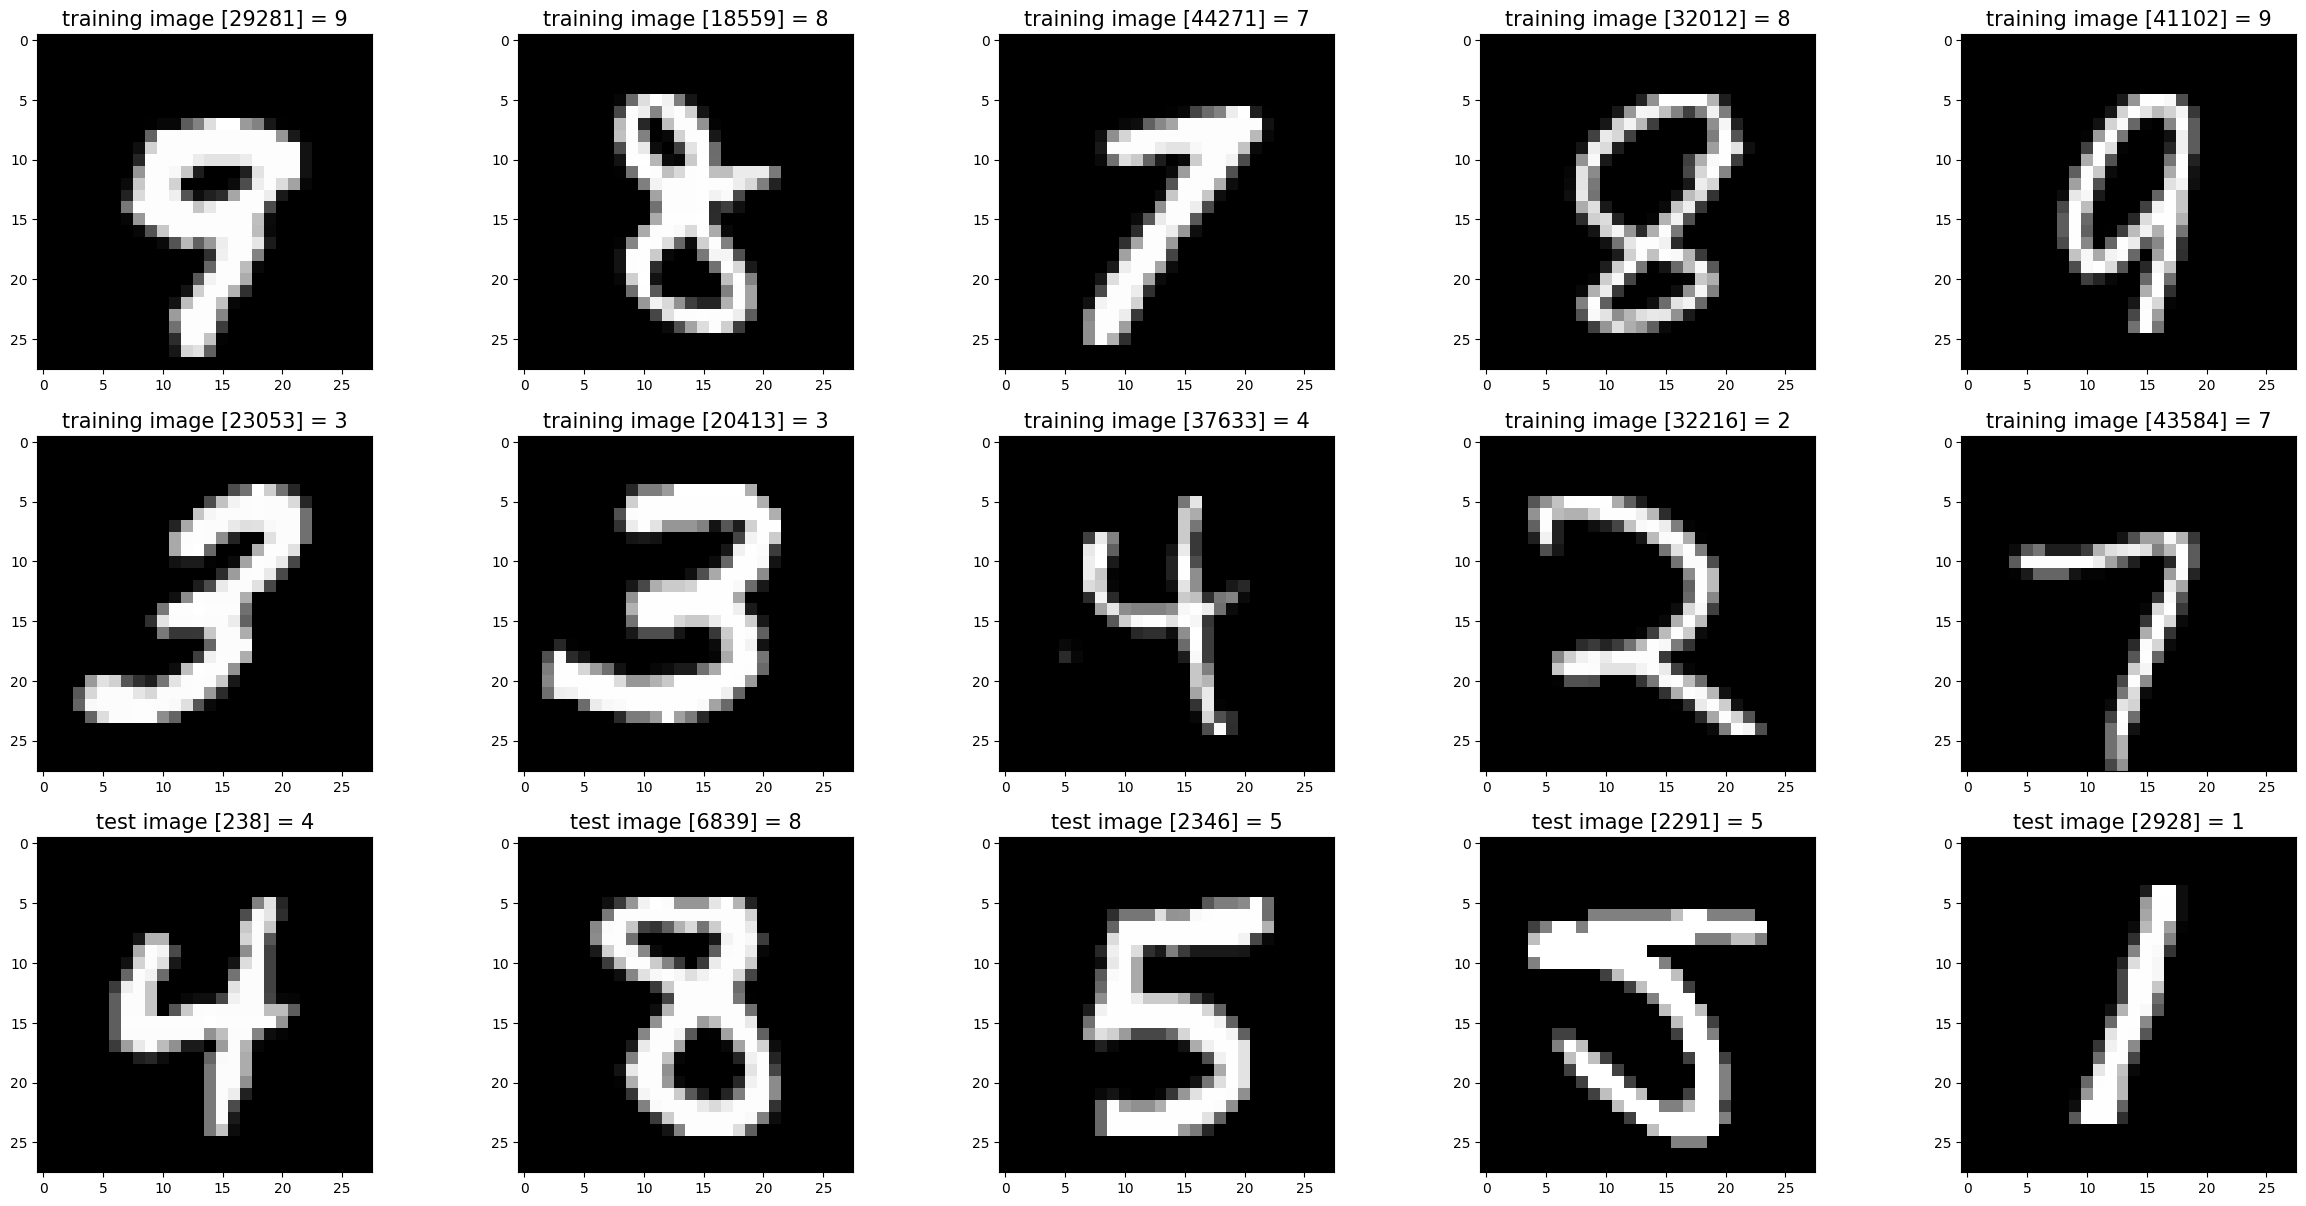

In [70]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'MNIST_Dataset'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)


#### Convert the data to numpy arrays

In [71]:
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int64)
y_test = np.array(y_test, dtype=np.int64)

#### Normalizing data to be in range [0, 1]

In [72]:
x_train /= 255.0
x_test /= 255.0

#### Combine and flatten data

In [73]:
X = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

X_flat = X.reshape(len(X), -1)  # (N, 784)


#### split data into training (60%), validation (20%), and test (20%) and flatten them

In [74]:
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

X_train_flat = X_train_full.reshape(-1, 28*28)
X_val_flat = X_val.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)


#### Convert all to PyTorch tensors

In [75]:
X_train_img = torch.tensor(X_train_full).unsqueeze(1)  # (N, 1, 28, 28)
X_val_img = torch.tensor(X_val).unsqueeze(1)
X_test_img = torch.tensor(X_test).unsqueeze(1)

X_train_flat = torch.tensor(X_train_flat)
X_val_flat = torch.tensor(X_val_flat)
X_test_flat = torch.tensor(X_test_flat)

y_train_t = torch.tensor(y_train_full)
y_val_t = torch.tensor(y_val)
y_test_t = torch.tensor(y_test)

#### Create TensorDatasets

In [76]:
train_dataset_img = TensorDataset(X_train_img, y_train_t)
val_dataset_img = TensorDataset(X_val_img, y_val_t)
test_dataset_img = TensorDataset(X_test_img, y_test_t)

train_dataset_flat = TensorDataset(X_train_flat, y_train_t)
val_dataset_flat = TensorDataset(X_val_flat, y_val_t)
test_dataset_flat = TensorDataset(X_test_flat, y_test_t)

#### Create DataLoaders

In [77]:
train_loader_img = DataLoader(train_dataset_img, batch_size=64, shuffle=True)
val_loader_img = DataLoader(val_dataset_img, batch_size=64, shuffle=False)
test_loader_img = DataLoader(test_dataset_img, batch_size=64, shuffle=False)

train_loader_flat = DataLoader(train_dataset_flat, batch_size=64, shuffle=True)
val_loader_flat = DataLoader(val_dataset_flat, batch_size=64, shuffle=False)
test_loader_flat = DataLoader(test_dataset_flat, batch_size=64, shuffle=False)

#### Verify Data Preparation

In [78]:
print(f"Train: {len(train_dataset_img)}, Val: {len(val_dataset_img)}, Test: {len(test_dataset_img)}")
print("Example batch:")
batch_imgs, batch_labels = next(iter(train_loader_img))
print(batch_imgs.shape, batch_labels.shape)

Train: 42000, Val: 14000, Test: 14000
Example batch:
torch.Size([64, 1, 28, 28]) torch.Size([64])


# A3 : Softmax Regression

In [79]:
#==================================
#===MODEL SETUP AND INITIAL EVAL===
#==================================

"""
Softmax Regression Implementation

Goal: Calculate probabilities for digit classes 0-9
- Z = W^T * x + b (linear transformation)
- Probabilities via softmax: exp(z_i) / Σ(exp(z_j))
- Loss via cross-entropy: -1/n * Σ log(p_correct)
"""

# Use NumPy version of the data
X_train_np = X_train_full.reshape(-1, 28*28)
y_train_np = y_train_full

# Initialize weights and biases
W = np.random.randn(784, 10) * 0.01  # Small random weights
b = np.zeros((1, 10))

# Forward pass with random weights
Zlogits = X_train_np @ W + b
exp_scores = np.exp(Zlogits)
probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

# Get predictions
predicted_classes = np.argmax(probabilities, axis=1)

# Calculate initial accuracy
initial_accuracy = np.mean(predicted_classes == y_train_np) * 100
print(f"Initial accuracy with random weights: {initial_accuracy:.2f}%")

# Calculate initial cross-entropy loss
n_samples = len(y_train_np)
correct_class_probs = probabilities[np.arange(n_samples), y_train_np]
loss = -np.mean(np.log(correct_class_probs + 1e-8))
print(f"Initial loss: {loss:.4f}")

Initial accuracy with random weights: 13.27%
Initial loss: 2.3118


### A3.2: SGD Training Loop

In [80]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 50
batch_size = 64

# Prepare validation data
X_val_np = X_val.reshape(-1, 28*28)
y_val_np = y_val

# Initialize tracking lists
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

n_train = len(X_train_np)
n_batches = n_train // batch_size

print(f"\n{'='*60}")
print("Starting Softmax Regression Training with SGD")
print(f"{'='*60}")
print(f"Learning rate: {learning_rate}")
print(f"Batch size: {batch_size}")
print(f"Total samples: {n_train}")
print(f"Batches per epoch: {n_batches}")
print(f"{'='*60}\n")

# Training loop
# an epoch is one complete pass through entire dataset
for epoch in range(num_epochs):
    # Shuffle training data
    indices = np.random.permutation(n_train)
    X_train_shuffled = X_train_np[indices]
    y_train_shuffled = y_train_np[indices]
    
    epoch_loss = 0
    
    # Mini-batch SGD
    #batches are subsets of data during each SGD iteration instead of
    #using entire dataset
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        X_batch = X_train_shuffled[start_idx:end_idx]
        y_batch = y_train_shuffled[start_idx:end_idx]
        
        # === FORWARD PASS (make predictions based on cur W) ===
        logits = X_batch @ W + b
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        
        batch_size_actual = len(y_batch)
        correct_probs = probs[np.arange(batch_size_actual), y_batch]
        batch_loss = -np.mean(np.log(correct_probs + 1e-8))
        epoch_loss += batch_loss
        
        # === BACKWARD PASS (calc gradient changes) ===
        y_one_hot = np.zeros_like(probs)
        y_one_hot[np.arange(batch_size_actual), y_batch] = 1
        dlogits = (probs - y_one_hot) / batch_size_actual
        dW = X_batch.T @ dlogits
        db = np.sum(dlogits, axis=0, keepdims=True)
        
        # === UPDATE WEIGHTS ===
        W -= learning_rate * dW
        b -= learning_rate * db
    
    # === EVALUATE ON TRAINING SET ===
    train_logits = X_train_np @ W + b
    train_exp = np.exp(train_logits - np.max(train_logits, axis=1, keepdims=True))
    train_probs = train_exp / np.sum(train_exp, axis=1, keepdims=True)
    train_pred = np.argmax(train_probs, axis=1)
    train_acc = np.mean(train_pred == y_train_np) * 100
    train_correct_probs = train_probs[np.arange(n_train), y_train_np]
    train_loss = -np.mean(np.log(train_correct_probs + 1e-8))
    
    # === EVALUATE ON VALIDATION SET ===
    val_logits = X_val_np @ W + b
    val_exp = np.exp(val_logits - np.max(val_logits, axis=1, keepdims=True))
    val_probs = val_exp / np.sum(val_exp, axis=1, keepdims=True)
    val_pred = np.argmax(val_probs, axis=1)
    val_acc = np.mean(val_pred == y_val_np) * 100
    n_val = len(y_val_np)
    val_correct_probs = val_probs[np.arange(n_val), y_val_np]
    val_loss = -np.mean(np.log(val_correct_probs + 1e-8))
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print progress each 5 epochs
    # if (epoch + 1) % 5 == 0:
    #     print(f"Epoch [{epoch+1}/{num_epochs}]")
    #     print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    #     print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    #     print()

# print(f"{'='*60}")
# print("Training completed!")
# print(f"{'='*60}\n")

# === TEST SET EVALUATION ===
X_test_np = X_test.reshape(-1, 28*28)
y_test_np = y_test

test_logits = X_test_np @ W + b
test_exp = np.exp(test_logits - np.max(test_logits, axis=1, keepdims=True))
test_probs = test_exp / np.sum(test_exp, axis=1, keepdims=True)
test_pred = np.argmax(test_probs, axis=1)
test_acc = np.mean(test_pred == y_test_np) * 100
n_test = len(y_test_np)
test_correct_probs = test_probs[np.arange(n_test), y_test_np]
test_loss = -np.mean(np.log(test_correct_probs + 1e-8))

print("Final Test Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.2f}%")


Starting Softmax Regression Training with SGD
Learning rate: 0.01
Batch size: 64
Total samples: 42000
Batches per epoch: 656

Final Test Results:
  Test Loss: 0.3045
  Test Accuracy: 91.35%


### A3.3: PyTorch Built-in Implementation

In [81]:
print("\n" + "="*60)
print("Comparing with PyTorch Built-in Implementation")
print("="*60 + "\n")

#PyTorch model
class SoftmaxRegressionPyTorch(nn.Module):
    def __init__(self, input_dim=784, num_classes=10):
        super(SoftmaxRegressionPyTorch, self).__init__()
        
        # self.linear creates a fully connected linear layer (also called dense layer)
        # It performs the operation: output = input @ W^T + b
        # 
        # Parameters:
        #   - input_dim (784): Number of input features (28×28 flattened image)
        #   - num_classes (10): Number of output classes (digits 0-9)
        #
        # This layer automatically creates and manages:
        #   - Weight matrix W: shape (10, 784) - learned during training
        #   - Bias vector b: shape (10,) - learned during training
        #
        # Note: PyTorch stores weights as (out_features, in_features), which is 
        # transposed compared to manual implementation where W is (784, 10)
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        # When called, self.linear(x) computes:
        # logits = x @ self.linear.weight.T + self.linear.bias
        # Input: (batch_size, 784) → Output: (batch_size, 10)
        return self.linear(x)

pytorch_model = SoftmaxRegressionPyTorch()
pytorch_criterion = nn.CrossEntropyLoss()
pytorch_optimizer = optim.SGD(pytorch_model.parameters(), lr=0.01)

pytorch_train_losses = []
pytorch_train_accs = []
pytorch_val_losses = []
pytorch_val_accs = []

print("Training PyTorch model...")
for epoch in range(num_epochs):
    pytorch_model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader_flat:
        outputs = pytorch_model(X_batch)
        loss = pytorch_criterion(outputs, y_batch)
        
        pytorch_optimizer.zero_grad()
        loss.backward()
        pytorch_optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    train_loss = epoch_loss / len(train_loader_flat)
    train_acc = 100 * correct / total
    
    pytorch_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader_flat:
            outputs = pytorch_model(X_batch)
            loss = pytorch_criterion(outputs, y_batch)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    val_loss = val_loss / len(val_loader_flat)
    val_acc = 100 * correct / total
    
    pytorch_train_losses.append(train_loss)
    pytorch_train_accs.append(train_acc)
    pytorch_val_losses.append(val_loss)
    pytorch_val_accs.append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

# Test evaluation
pytorch_model.eval()
pytorch_test_preds = []
with torch.no_grad():
    for X_batch, _ in test_loader_flat:
        outputs = pytorch_model(X_batch)
        _, predicted = torch.max(outputs, 1)
        pytorch_test_preds.extend(predicted.cpu().numpy())

pytorch_test_acc = np.mean(np.array(pytorch_test_preds) == y_test_np) * 100

print("\n" + "="*60)
print("Final Comparison: Manual vs PyTorch")
print("="*60)
print(f"Manual Implementation - Test Accuracy: {test_acc:.2f}%")
print(f"PyTorch Implementation - Test Accuracy: {pytorch_test_acc:.2f}%")
print(f"Difference: {abs(test_acc - pytorch_test_acc):.2f}%")


Comparing with PyTorch Built-in Implementation

Training PyTorch model...
Epoch [10/50] - Train Loss: 0.3725, Train Acc: 89.98%, Val Acc: 89.74%
Epoch [20/50] - Train Loss: 0.3292, Train Acc: 90.92%, Val Acc: 90.51%
Epoch [30/50] - Train Loss: 0.3103, Train Acc: 91.47%, Val Acc: 90.94%
Epoch [40/50] - Train Loss: 0.2989, Train Acc: 91.80%, Val Acc: 91.13%
Epoch [50/50] - Train Loss: 0.2905, Train Acc: 91.99%, Val Acc: 91.32%

Final Comparison: Manual vs PyTorch
Manual Implementation - Test Accuracy: 91.35%
PyTorch Implementation - Test Accuracy: 91.37%
Difference: 0.02%


### A3.4: Training Curves, Confusion Matrix & Per-Class Analysis

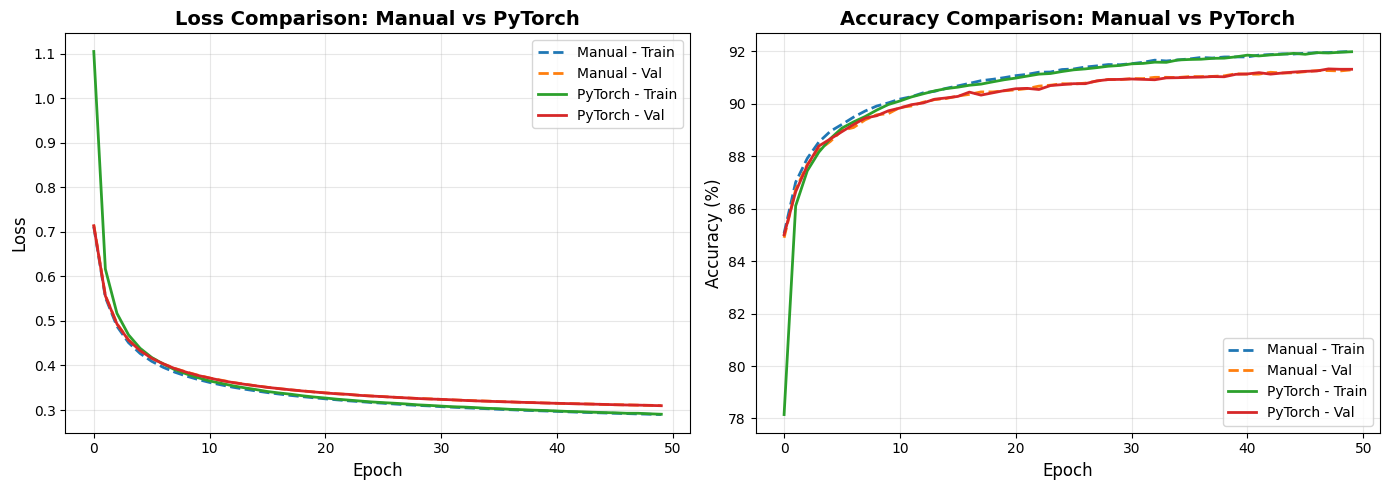


CONFUSION MATRIX ANALYSIS



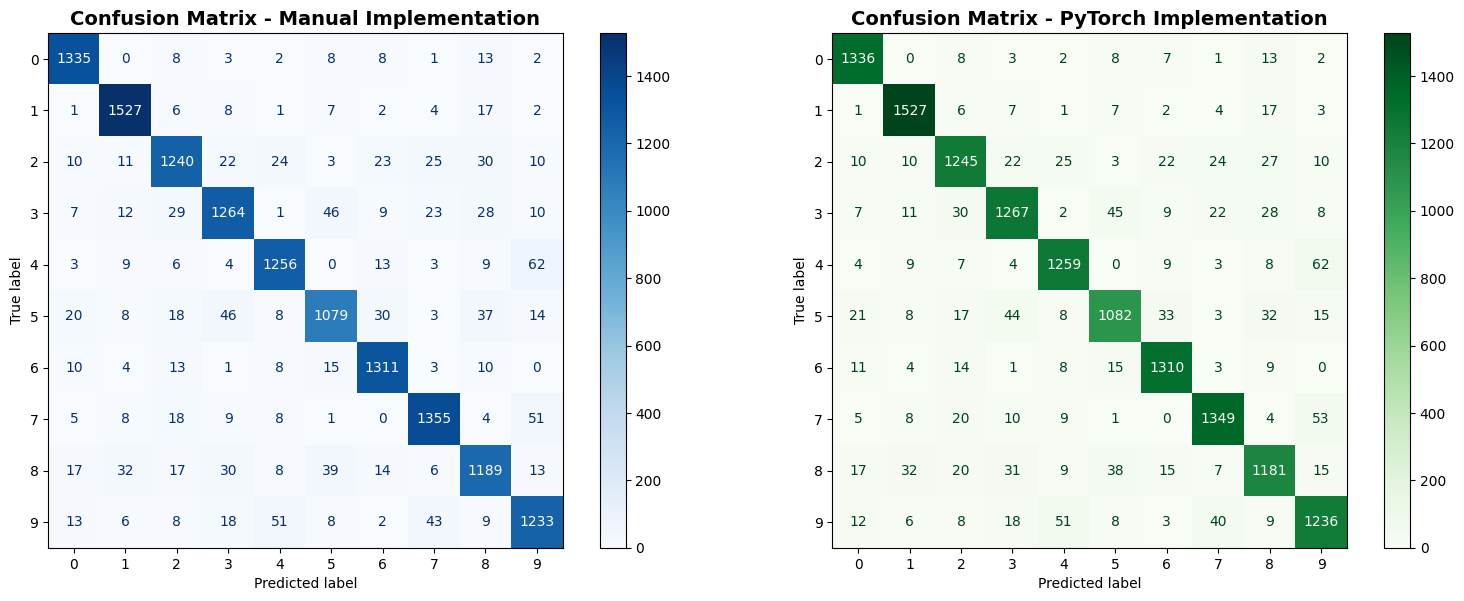


Manual Implementation:
  Diagonal sum (correct predictions): 12789
  Total predictions: 14000
  Accuracy from CM: 91.35%

PyTorch Implementation:
  Diagonal sum (correct predictions): 12792
  Total predictions: 14000
  Accuracy from CM: 91.37%

PER-CLASS ACCURACY ANALYSIS

Class | Manual Acc | PyTorch Acc | Test Samples
-------------------------------------------------------
  0   |   96.74%  |   96.81%   |     1380
  1   |   96.95%  |   96.95%   |     1575
  2   |   88.70%  |   89.06%   |     1398
  3   |   88.45%  |   88.66%   |     1429
  4   |   92.01%  |   92.23%   |     1365
  5   |   85.43%  |   85.67%   |     1263
  6   |   95.35%  |   95.27%   |     1375
  7   |   92.87%  |   92.46%   |     1459
  8   |   87.11%  |   86.52%   |     1365
  9   |   88.64%  |   88.86%   |     1391


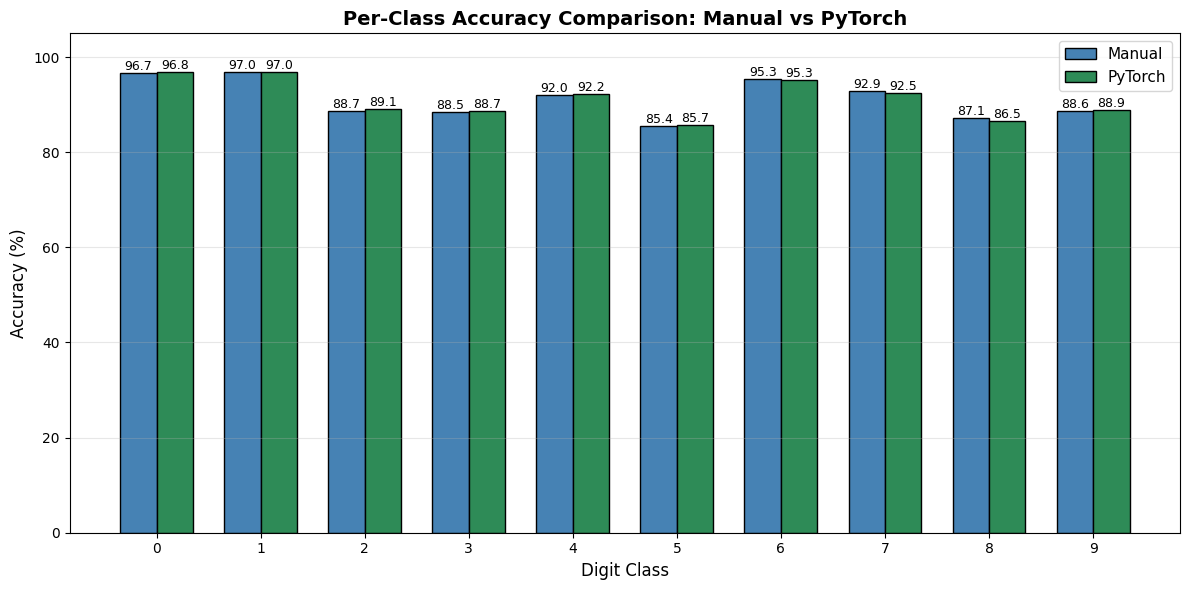


Manual Implementation:
  Best performing class: 1 (96.95%)
  Worst performing class: 5 (85.43%)

PyTorch Implementation:
  Best performing class: 1 (96.95%)
  Worst performing class: 5 (85.67%)


In [82]:
# === TRAINING CURVES COMPARISON ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Manual - Train', linewidth=2, linestyle='--')
ax1.plot(val_losses, label='Manual - Val', linewidth=2, linestyle='--')
ax1.plot(pytorch_train_losses, label='PyTorch - Train', linewidth=2)
ax1.plot(pytorch_val_losses, label='PyTorch - Val', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss Comparison: Manual vs PyTorch', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(train_accuracies, label='Manual - Train', linewidth=2, linestyle='--')
ax2.plot(val_accuracies, label='Manual - Val', linewidth=2, linestyle='--')
ax2.plot(pytorch_train_accs, label='PyTorch - Train', linewidth=2)
ax2.plot(pytorch_val_accs, label='PyTorch - Val', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Accuracy Comparison: Manual vs PyTorch', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === CONFUSION MATRIX ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("\n" + "="*60)
print("CONFUSION MATRIX ANALYSIS")
print("="*60 + "\n")

cm_manual = confusion_matrix(y_test_np, test_pred)
cm_pytorch = confusion_matrix(y_test_np, pytorch_test_preds)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=np.arange(10))
disp1.plot(cmap='Blues', ax=ax1, values_format='d')
ax1.set_title('Confusion Matrix - Manual Implementation', fontsize=14, fontweight='bold')

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_pytorch, display_labels=np.arange(10))
disp2.plot(cmap='Greens', ax=ax2, values_format='d')
ax2.set_title('Confusion Matrix - PyTorch Implementation', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nManual Implementation:")
print(f"  Diagonal sum (correct predictions): {np.trace(cm_manual)}")
print(f"  Total predictions: {np.sum(cm_manual)}")
print(f"  Accuracy from CM: {(np.trace(cm_manual) / np.sum(cm_manual)) * 100:.2f}%")

print("\nPyTorch Implementation:")
print(f"  Diagonal sum (correct predictions): {np.trace(cm_pytorch)}")
print(f"  Total predictions: {np.sum(cm_pytorch)}")
print(f"  Accuracy from CM: {(np.trace(cm_pytorch) / np.sum(cm_pytorch)) * 100:.2f}%")

# === PER-CLASS ACCURACY ===
print("\n" + "="*60)
print("PER-CLASS ACCURACY ANALYSIS")
print("="*60 + "\n")

per_class_acc_manual = []
per_class_acc_pytorch = []

for class_idx in range(10):
    class_mask = (y_test_np == class_idx)
    class_correct_manual = np.sum((test_pred == class_idx) & class_mask)
    class_total = np.sum(class_mask)
    acc_manual = (class_correct_manual / class_total) * 100 if class_total > 0 else 0
    per_class_acc_manual.append(acc_manual)
    
    class_correct_pytorch = np.sum((np.array(pytorch_test_preds) == class_idx) & class_mask)
    acc_pytorch = (class_correct_pytorch / class_total) * 100 if class_total > 0 else 0
    per_class_acc_pytorch.append(acc_pytorch)

print("Class | Manual Acc | PyTorch Acc | Test Samples")
print("-" * 55)
for i in range(10):
    print(f"  {i}   |   {per_class_acc_manual[i]:5.2f}%  |   {per_class_acc_pytorch[i]:5.2f}%   |     {np.sum(y_test_np == i):4d}")

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(10)
width = 0.35

bars1 = ax.bar(x - width/2, per_class_acc_manual, width, label='Manual', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, per_class_acc_pytorch, width, label='PyTorch', color='seagreen', edgecolor='black')

ax.set_xlabel('Digit Class', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Class Accuracy Comparison: Manual vs PyTorch', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_ylim([0, 105])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

best_class_manual = np.argmax(per_class_acc_manual)
worst_class_manual = np.argmin(per_class_acc_manual)

print(f"\nManual Implementation:")
print(f"  Best performing class: {best_class_manual} ({per_class_acc_manual[best_class_manual]:.2f}%)")
print(f"  Worst performing class: {worst_class_manual} ({per_class_acc_manual[worst_class_manual]:.2f}%)")

best_class_pytorch = np.argmax(per_class_acc_pytorch)
worst_class_pytorch = np.argmin(per_class_acc_pytorch)

print(f"\nPyTorch Implementation:")
print(f"  Best performing class: {best_class_pytorch} ({per_class_acc_pytorch[best_class_pytorch]:.2f}%)")
print(f"  Worst performing class: {worst_class_pytorch} ({per_class_acc_pytorch[worst_class_pytorch]:.2f}%)")

### A3.5: Final Summary For SoftMax

In [83]:
print("\n" + "="*70)
print("          SOFTMAX REGRESSION - FINAL SUMMARY REPORT")
print("="*70)

print("\nDATASET INFORMATION:")
print(f"  • Training samples:   {len(X_train_np):,}")
print(f"  • Validation samples: {len(X_val_np):,}")
print(f"  • Test samples:       {len(X_test_np):,}")
print(f"  • Input features:     784 (28x28 pixels)")
print(f"  • Output classes:     10 (digits 0-9)")

print("\nHYPERPARAMETERS:")
print(f"  • Learning rate:      {learning_rate}")
print(f"  • Batch size:         {batch_size}")
print(f"  • Number of epochs:   {num_epochs}")
print(f"  • Optimizer:          Stochastic Gradient Descent (SGD)")
print(f"  • Loss function:      Cross-Entropy")
print(f"  • Weight initialization: Random normal (μ=0, σ=0.01)")

print("\nMANUAL IMPLEMENTATION RESULTS:")
print(f"  • Initial accuracy:     {initial_accuracy:.2f}%")
print(f"  • Initial loss:         {loss:.4f}")
print(f"  • Final train accuracy: {train_accuracies[-1]:.2f}%")
print(f"  • Final train loss:     {train_losses[-1]:.4f}")
print(f"  • Final val accuracy:   {val_accuracies[-1]:.2f}%")
print(f"  • Final val loss:       {val_losses[-1]:.4f}")
print(f"  • Test accuracy:        {test_acc:.2f}%")
print(f"  • Test loss:            {test_loss:.4f}")

print("\nPYTORCH IMPLEMENTATION RESULTS:")
print(f"  • Final train accuracy: {pytorch_train_accs[-1]:.2f}%")
print(f"  • Final val accuracy:   {pytorch_val_accs[-1]:.2f}%")
print(f"  • Test accuracy:        {pytorch_test_acc:.2f}%")

print("\nCOMPARISON:")
print(f"  • Accuracy difference:  {abs(test_acc - pytorch_test_acc):.2f}%")
print(f"  • Verification status:  ", end="")

print("\nTRAINING INSIGHTS:")
improvement = train_accuracies[-1] - train_accuracies[0]
print(f"  • Training improvement: {improvement:.2f}% (from {train_accuracies[0]:.2f}% to {train_accuracies[-1]:.2f}%)")
if train_accuracies[-1] - val_accuracies[-1] > 5:
    print(f"  • Overfitting detected: Train acc ({train_accuracies[-1]:.2f}%) >> Val acc ({val_accuracies[-1]:.2f}%)")
else:
    print(f"  • Good generalization: Train-Val gap is {abs(train_accuracies[-1] - val_accuracies[-1]):.2f}%")

print("\nBEST/WORST CLASSES:")
print(f"  • Best class (Manual):  Digit {best_class_manual} with {per_class_acc_manual[best_class_manual]:.2f}% accuracy")
print(f"  • Worst class (Manual): Digit {worst_class_manual} with {per_class_acc_manual[worst_class_manual]:.2f}% accuracy")


          SOFTMAX REGRESSION - FINAL SUMMARY REPORT

DATASET INFORMATION:
  • Training samples:   42,000
  • Validation samples: 14,000
  • Test samples:       14,000
  • Input features:     784 (28x28 pixels)
  • Output classes:     10 (digits 0-9)

HYPERPARAMETERS:
  • Learning rate:      0.01
  • Batch size:         64
  • Number of epochs:   50
  • Optimizer:          Stochastic Gradient Descent (SGD)
  • Loss function:      Cross-Entropy
  • Weight initialization: Random normal (μ=0, σ=0.01)

MANUAL IMPLEMENTATION RESULTS:
  • Initial accuracy:     13.27%
  • Initial loss:         0.1318
  • Final train accuracy: 92.00%
  • Final train loss:     0.2898
  • Final val accuracy:   91.30%
  • Final val loss:       0.3099
  • Test accuracy:        91.35%
  • Test loss:            0.3045

PYTORCH IMPLEMENTATION RESULTS:
  • Final train accuracy: 91.99%
  • Final val accuracy:   91.32%
  • Test accuracy:        91.37%

COMPARISON:
  • Accuracy difference:  0.02%
  • Verification status: